In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix, classification_report,
    confusion_matrix, roc_curve, auc,
    brier_score_loss
)
import warnings

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df_login=pd.read_csv("../EDA_transform/data/login_transform.csv",dtype={'vopenid':'object'})
df_purchase=pd.read_csv("../EDA_transform/data/purchase_transform.csv",dtype={'vopenid':'object'})
df_login.shape,df_purchase.shape

((114380, 17), (25625, 9))

In [5]:
df_login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114380 entries, 0 to 114379
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   vopenid                114379 non-null  object 
 1   last_update_time       114380 non-null  object 
 2   num_day_login          114380 non-null  int64  
 3   avg_login_per_day      114380 non-null  float64
 4   avg_between_login      114380 non-null  float64
 5   streak_login           114380 non-null  int64  
 6   last_since_from_login  114380 non-null  int64  
 7   popular_time_login     114380 non-null  int64  
 8   gold_std_login         114380 non-null  float64
 9   diamond_std_login      114380 non-null  float64
 10  silkcoin_std_login     114380 non-null  float64
 11  gold_slope_login       114380 non-null  float64
 12  diamond_slope_login    114380 non-null  float64
 13  silkcoin_slope_login   114380 non-null  float64
 14  powerpoint_last_login  114380 non-nu

In [6]:
df_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25625 entries, 0 to 25624
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   vopenid                   25625 non-null  object 
 1   last_update_time          25625 non-null  object 
 2   num_purchase              25625 non-null  int64  
 3   total_purchase            25625 non-null  float64
 4   count_purchase_per_day    25625 non-null  float64
 5   std_amount_purchase       25625 non-null  float64
 6   max_purchase              25625 non-null  float64
 7   days_since_last_purchase  25625 non-null  int64  
 8   num_product_buyed         25625 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 1.8+ MB


In [7]:
df_purchase_rename = df_purchase.rename(columns={'last_update_time': 'last_update_time_purchase'}) # rename to prepare to merged
df_merged = df_login.merge(
    df_purchase_rename.drop(columns=['last_update_time_purchase']),
    on='vopenid',
    how='left'
)
df_merged['has_purchase'] = (~df_merged['total_purchase'].isnull()).astype(int)
df_merged.shape

(114380, 25)

In [8]:
del df_login
del df_purchase

In [9]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114380 entries, 0 to 114379
Data columns (total 25 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   vopenid                   114379 non-null  object 
 1   last_update_time          114380 non-null  object 
 2   num_day_login             114380 non-null  int64  
 3   avg_login_per_day         114380 non-null  float64
 4   avg_between_login         114380 non-null  float64
 5   streak_login              114380 non-null  int64  
 6   last_since_from_login     114380 non-null  int64  
 7   popular_time_login        114380 non-null  int64  
 8   gold_std_login            114380 non-null  float64
 9   diamond_std_login         114380 non-null  float64
 10  silkcoin_std_login        114380 non-null  float64
 11  gold_slope_login          114380 non-null  float64
 12  diamond_slope_login       114380 non-null  float64
 13  silkcoin_slope_login      114380 non-null  f

In [10]:
df_merged['last_update_time'] = pd.to_datetime(df_merged['last_update_time'])
df_merged['last_update_time'].dtypes

datetime64[ns, UTC]

In [11]:
df_merged['last_update_time'].min(),df_merged['last_update_time'].max()

(Timestamp('2025-05-14 17:00:04+0000', tz='UTC'),
 Timestamp('2025-05-19 14:52:51+0000', tz='UTC'))

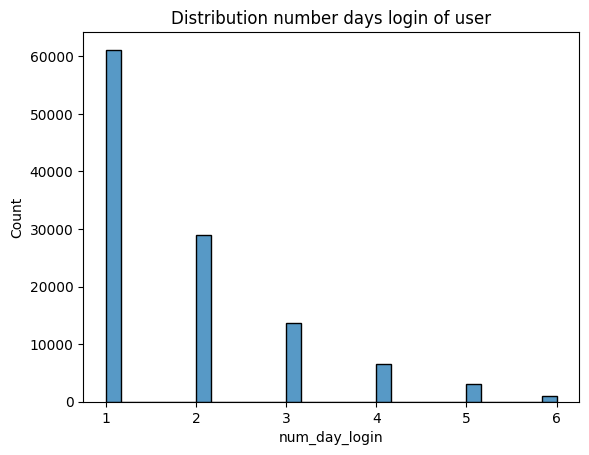

In [12]:
sns.histplot(df_merged['num_day_login'], bins=30)
plt.title('Distribution number days login of user')
plt.show()

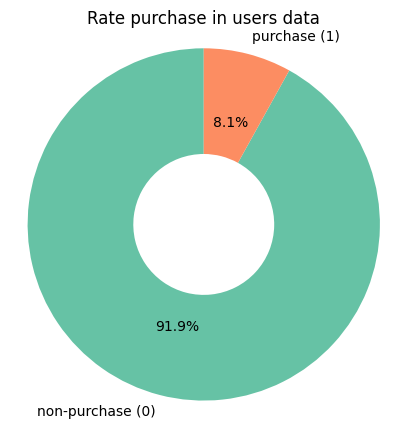

In [13]:
counts = df_merged['has_purchase'].value_counts().sort_index()
labels = ['non-purchase (0)', 'purchase (1)']

colors = sns.color_palette('Set2', n_colors=2)

plt.figure(figsize=(5,5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=0.6))
plt.title('Rate purchase in users data', fontsize=12)
plt.axis('equal')
plt.show()

In [16]:
now = pd.Timestamp('2025-06-16 12:00:00', tz='UTC')
df_merged['days_since_last_login'] = (now - df_merged['last_update_time']).dt.days
df_merged['churn'] = (df_merged['days_since_last_login'] >= 7).astype(int)

df_merged[['vopenid','last_update_time','has_purchase','churn']].head(10)

,vopenid,last_update_time,has_purchase,churn
0,zZzHoaLanzZz,2025-05-19 03:03:46+00:00,0,1
1,!YếnNhi!,2025-05-19 03:10:43+00:00,0,1
2,"""""""TiểuTuyết""""""",2025-05-17 07:20:28+00:00,0,1
3,"""VoiRừng""",2025-05-19 03:05:23+00:00,0,1
4,"""rose""",2025-05-19 03:09:12+00:00,0,1
5,''Ari68'',2025-05-19 03:04:23+00:00,0,1
6,'Ros',2025-05-19 03:10:37+00:00,0,1
7,0.0,2025-05-16 13:42:15+00:00,0,1
8,000Ja9,2025-05-17 07:20:55+00:00,0,1
9,00FF00ĐjtMẹNPH,2025-05-19 03:09:36+00:00,0,1


In [19]:
purchase_cols = [
    'num_purchase', 
    'total_purchase',
    'max_purchase',
    'days_since_last_purchase',
    'num_product_buyed'
]
df_merged=df_merged.drop(columns=purchase_cols,axis=1)

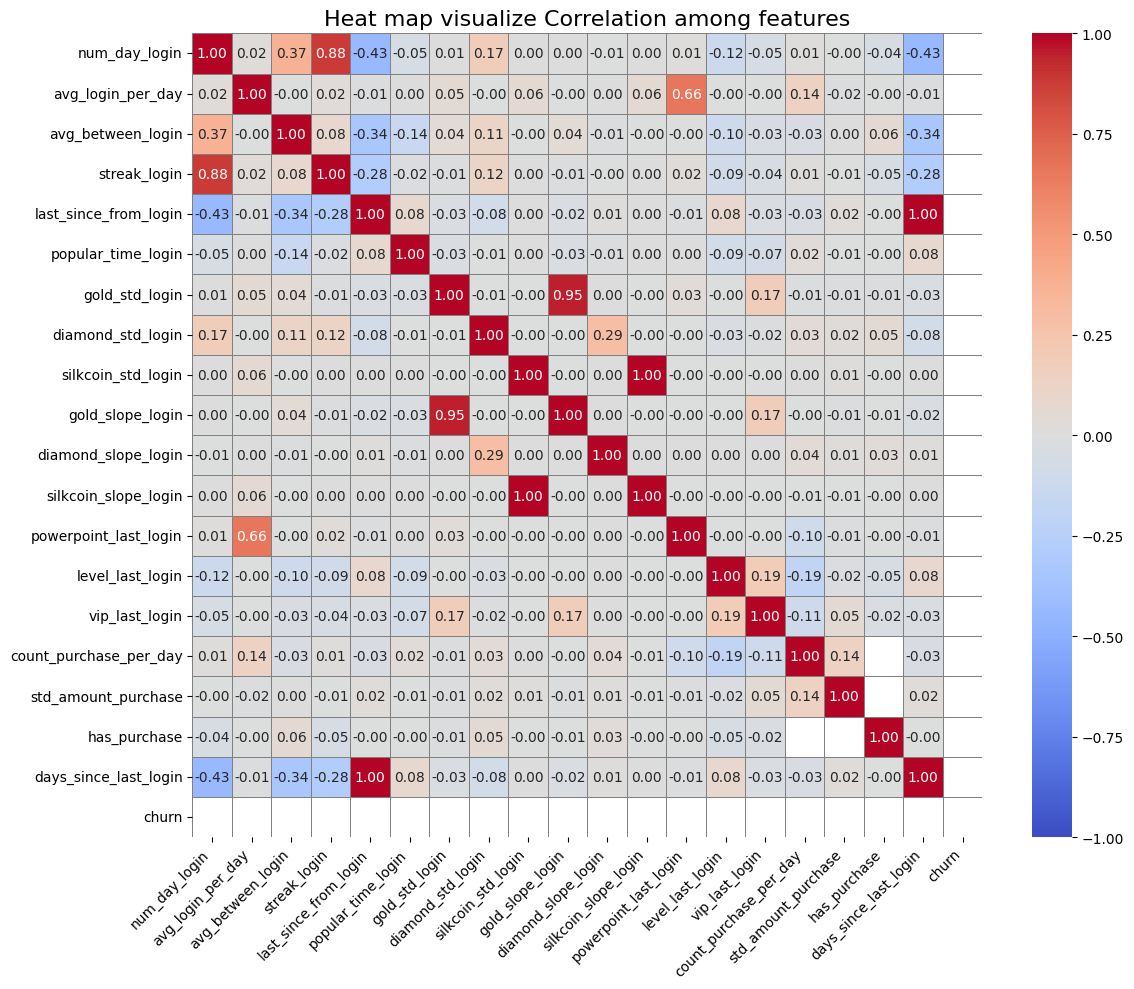

In [20]:
corr_cols = df_merged.drop(columns=['vopenid', 'last_update_time']).columns

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,        
    fmt=".2f",
    cmap="coolwarm",    
    vmin=-1,           
    vmax=1,
    center=0,        
    linewidths=0.5,     
    linecolor='gray' 
)

plt.title('Heat map visualize Correlation among features', fontsize=16)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [22]:
corr_matrix = df_merged[corr_cols].corr()
corr_matrix

,num_day_login,avg_login_per_day,avg_between_login,streak_login,last_since_from_login,popular_time_login,gold_std_login,diamond_std_login,silkcoin_std_login,gold_slope_login,diamond_slope_login,silkcoin_slope_login,powerpoint_last_login,level_last_login,vip_last_login,count_purchase_per_day,std_amount_purchase,has_purchase,days_since_last_login,churn
num_day_login,1.00,0.02,0.37,0.88,-0.43,-0.05,0.01,0.17,0.00,0.00,-0.01,0.00,0.01,-0.12,-0.05,0.01,-0.00,-0.04,-0.43,NaN
avg_login_per_day,0.02,1.00,-0.00,0.02,-0.01,0.00,0.05,-0.00,0.06,-0.00,0.00,0.06,0.66,-0.00,-0.00,0.14,-0.02,-0.00,-0.01,NaN
avg_between_login,0.37,-0.00,1.00,0.08,-0.34,-0.14,0.04,0.11,-0.00,0.04,-0.01,-0.00,-0.00,-0.10,-0.03,-0.03,0.00,0.06,-0.34,NaN
streak_login,0.88,0.02,0.08,1.00,-0.28,-0.02,-0.01,0.12,0.00,-0.01,-0.00,0.00,0.02,-0.09,-0.04,0.01,-0.01,-0.05,-0.28,NaN
last_since_from_login,-0.43,-0.01,-0.34,-0.28,1.00,0.08,-0.03,-0.08,0.00,-0.02,0.01,0.00,-0.01,0.08,-0.03,-0.03,0.02,-0.00,1.00,NaN
popular_time_login,-0.05,0.00,-0.14,-0.02,0.08,1.00,-0.03,-0.01,0.00,-0.03,-0.01,0.00,0.00,-0.09,-0.07,0.02,-0.01,-0.00,0.08,NaN
gold_std_login,0.01,0.05,0.04,-0.01,-0.03,-0.03,1.00,-0.01,-0.00,0.95,0.00,-0.00,0.03,-0.00,0.17,-0.01,-0.01,-0.01,-0.03,NaN
diamond_std_login,0.17,-0.00,0.11,0.12,-0.08,-0.01,-0.01,1.00,-0.00,-0.00,0.29,-0.00,-0.00,-0.03,-0.02,0.03,0.02,0.05,-0.08,NaN
silkcoin_std_login,0.00,0.06,-0.00,0.00,0.00,0.00,-0.00,-0.00,1.00,-0.00,0.00,1.00,-0.00,-0.00,-0.00,0.00,0.01,-0.00,0.00,NaN
gold_slope_login,0.00,-0.00,0.04,-0.01,-0.02,-0.03,0.95,-0.00,-0.00,1.00,0.00,-0.00,-0.00,-0.00,0.17,-0.00,-0.01,-0.01,-0.02,NaN
